**Sarcasm Detection with GloVe + LSTM**

Explored the following hypothesis with RNN:
- Stacking of parent comment
- Stacking of augmented features
- Use of bidirectional layer
- Keras Tuning of parameters

In [ ]:
# For logging into cluster
# !gcloud auth login
# !gcloud compute ssh --zone "asia-southeast1-b" "sarcasm-detectio"  --project "sarcasmdetection-364607"
# !pip install keras-tuner --upgrade

In [ ]:
import numpy as np 
import pandas as pd 
import keras
import os
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Concatenate, Input, concatenate, SimpleRNN
from keras import Input, Model
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
# import keras_tuner
# from keras.layers.embeddings import Embedding

In [ ]:
# Ensure that files have been uploaded onto Drive
# Mount onto drive and change into directory
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/archive

Mounted at /content/drive
/content/drive/MyDrive/archive


In [ ]:
# -- Load datasets --
data = pd.read_csv('train-balanced-sarcasm.csv')

In [ ]:
# -- Additional feature extraction --

tags = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
import string

def alphabet_rep(text):
  count = 0
  letter = text[0]
  for i in text:
    if count > 2 :
      return 1
    if i == letter:
      count += 1
    else:
      letter = i
  return 0

def exclamation_freq(text):
  count = 0
  for i in text:
    if i == "!":
      count += 1
  freq = count/len(text)
  return freq

def question_freq(text):
  count = 0
  for i in text:
    if i == "?":
      count += 1
  freq = count/len(text)
  return freq

def dots_freq(text):
  count = 0
  for i in text:
    if i == ".":
      count += 1
  freq = count/len(text)
  return freq

def caps_freq(text):
  count = 0
  for i in text:
    if i.isupper():
      count += 1
  return count/len(text)

def quotes_freq(text):
  count = 0
  for i in text:
    if i in  ("\'" ,"\""):
      count += 1
  freq = count/len(text)
  return freq

def consecutive_caps(text):
  n = len(text)
  count = 0
  for i in range(n):
    if (i < n - 1 and text[i].isupper() and text[i+1].isupper()):
      if i == 0 and text[i].isupper():
        count += 1
      if i > 0 and not text[i - 1].isupper():
        count += 1
      count += 1
  
  freq = count/len(text)
  return freq

def consecutive_dots(text):
  n = len(text)
  count = 0
  for i in range(n):
    if (i < n - 1 and text[i] == "." and text[i+1] == "."):
      if i == 0 and text[i] == ".":
        count += 1
      if i > 0 and not text[i - 1] == ".":
        count += 1
      count += 1
  
  freq = count/len(text)
  return freq

def consecutive_exclamations(text):
  n = len(text)
  count = 0
  for i in range(n):
    if (i < n - 1 and text[i] == "!" and text[i+1] == "!"):
      if i == 0 and text[i] == "!":
        count += 1
      if i > 0 and not text[i - 1] == "!":
        count += 1
      count += 1
  
  freq = count/len(text)
  return freq

def consecutive_question(text):
  n = len(text)
  count = 0
  for i in range(n):
    if (i < n - 1 and text[i] == "?" and text[i+1] == "?"):
      if i == 0 and text[i] == "?":
        count += 1
      if i > 0 and not text[i - 1] == "?":
        count += 1
      count += 1

  freq = count/len(text)
  return freq

def consecutive_punctuations(text):
  n = len(text)
  count = 0
  for i in range(n):
    if (i < n - 1 and text[i] in string.punctuation and text[i+1] in string.punctuation):
      if i == 0 and text[i] in string.punctuation:
        count += 1
      if i > 0 and not text[i - 1] in string.punctuation:
        count += 1
      count += 1

  freq = count/len(text)
  return freq


In [ ]:
def add_new_features(df, col_name=""):
  df_copy = df.copy()
  df_copy['meta_features'] = df[col_name].apply(lambda x: [0,0,0,0,0,0,0,0,0] if x != x else [quotes_freq(x), question_freq(x), dots_freq(x), exclamation_freq(x), alphabet_rep(x), consecutive_caps(x), consecutive_exclamations(x), consecutive_question(x), consecutive_punctuations(x)]) 
  # df_copy['meta_features'] = df[col_name].apply(lambda x: [0,0,0,0,0] if x != x else [alphabet_rep(x), consecutive_caps(x), consecutive_exclamations(x), consecutive_question(x), consecutive_punctuations(x)])
  df_copy = df_copy.fillna(0)
  return df_copy

augmented_data = add_new_features(data, col_name="comment")
augmented_data = augmented_data.drop(columns=['parent_comment', 'score', 'downs', 'ups', 'author', 'subreddit', 'date', 'created_utc'])
augmented_data

,label,comment,meta_features
0,0,NC and NH.,"[0.0, 0.0, 0.1, 0.0, 0, 0.4, 0.0, 0.0, 0.0]"
1,0,You do know west teams play against west teams...,"[0.0, 0.013513513513513514, 0.0, 0.0, 0, 0.0, ..."
2,0,"They were underdogs earlier today, but since G...","[0.008264462809917356, 0.0, 0.0, 0.0, 1, 0.0, ..."
3,0,"This meme isn't funny none of the ""new york ni...","[0.05, 0.0, 0.016666666666666666, 0.0, 1, 0.0,..."
4,0,I could use one of those tools.,"[0.0, 0.0, 0.03225806451612903, 0.0, 0, 0.0, 0..."
...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,"[0.010869565217391304, 0.0, 0.0217391304347826..."
1010822,1,"whatever you do, don't vote green!","[0.029411764705882353, 0.0, 0.0, 0.02941176470..."
1010823,1,Perhaps this is an atheist conspiracy to make ...,"[0.0, 0.015151515151515152, 0.0, 0.0, 0, 0.0, ..."
1010824,1,The Slavs got their own country - it is called...,"[0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0]"


In [ ]:
# -- Helper Functions for Data Cleaning --

def clean_text(text):
    text = str(text)
    text = re.sub(r"i'm", "i am", text) # Expanding the word to full form
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text) # Remove stop punctuations
    return text

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def CleanTokenize(df, column_name):
    head_lines = list()
    lines = df[column_name].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove punctuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Extract tokens from comments
# Uncomment if testing on standard data
# augmented_data = data
cleaned_tokens = CleanTokenize(augmented_data, 'comment')

In [ ]:
# -- Train Test Split --
validation_split = 0.2
max_length = 25

# -- Normal Comment --
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(cleaned_tokens)
# To limit number of words
# tokenizer_obj.num_words = 160000
sequences = tokenizer_obj.texts_to_sequences(cleaned_tokens)

word_index = tokenizer_obj.word_index
print("unique tokens - ", len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  augmented_data['label'].values

# -- Shuffle Data --

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]
# lines_pad_parent = lines_pad_parent[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

# Adjust depending on type of hypothesis tested
x_train_meta_all = np.array([np.array(x) for x in augmented_data['meta_features']])

# X_train_score = augmented_data[:-num_validation_samples]['score'].to_numpy()
# X_train_pcomment = lines_pad_parent[:-num_validation_samples]
X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
x_train_meta = x_train_meta_all[:-num_validation_samples]
# X_test_score = augmented_data[-num_validation_samples:]['score'].to_numpy()
# X_test_pcomment = lines_pad_parent[-num_validation_samples:]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]
x_test_meta = x_train_meta_all[-num_validation_samples:]

unique tokens -  190557
vocab size - 190558


In [ ]:
# -- Get shape of training dataset --

print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of x_train_meta:', x_train_meta.shape)
print('Shape of x_test_meta:', x_test_meta.shape)


Shape of X_train_pad: (808661, 25)
Shape of X_test_pad: (202165, 25)
Shape of x_train_meta: (808661, 9)
Shape of x_test_meta: (202165, 9)


In [ ]:
# -- Download and retrieve GloVe model --

# !wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
# !unzip glove.twitter.27B.zip
# %ls

In [ ]:
# -- Load GloVe model --

"""
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. 
Training is performed on aggregated global word-word co-occurrence statistics from a corpus, 
and the resulting representations showcase interesting linear substructures of the word vector space.
"""
embeddings_index = {}
embedding_dim = 100
f = open('./glove.twitter.27B.100d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [ ]:
def build_embedding_layer():
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
  c = 0
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          c+=1
          embedding_matrix[i] = embedding_vector
  print(c)

  embedding_layer = Embedding(len(word_index) + 1,
                              embedding_dim,
                              weights=[embedding_matrix],
                              input_length=max_length,
                              trainable=False)
  return embedding_layer

91676


In [ ]:
# Embedding layer for parent comment if testing with parent commment

# embedding_matrix_parent = np.zeros((len(word_index_parent) + 1, embedding_dim))
# c = 0
# for word, i in word_index_parent.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         c+=1
#         embedding_matrix_parent[i] = embedding_vector
# print(c)

# embedding_layer_parent = Embedding(len(word_index_parent) + 1,
#                             embedding_dim,
#                             weights=[embedding_matrix],
#                             input_length=max_length,
#                             trainable=False)

111786


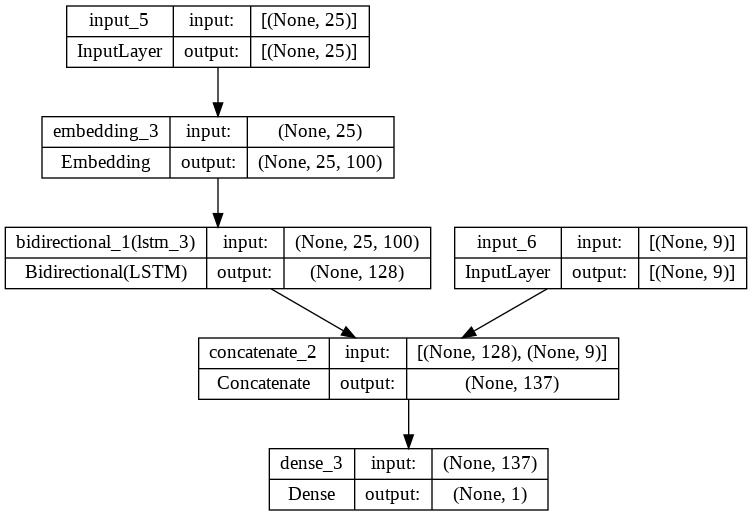

In [ ]:
# Link on how to stack features 
# https://towardsdatascience.com/combining-numerical-and-text-features-in-deep-neural-networks-e91f0237eea4

from tensorflow.keras.utils import plot_model

def build_meta_model(num_features=9, seq_length=25, isBidirectional=False):

  embedding_size = len(word_index) + 1
  nlp_input = Input(shape=(seq_length,)) 
  meta_input = Input(shape=(num_features,))
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
  emb = Embedding(len(word_index) + 1,
                              embedding_dim,
                              weights=[embedding_matrix],
                              input_length=max_length,
                              trainable=False)(nlp_input)
  
  c = 0
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          c+=1
          embedding_matrix[i] = embedding_vector 
                            
  if isBidirectional:
    nlp_out = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.25))(emb)
  else:                            
    nlp_out = LSTM(64, dropout=0.2, recurrent_dropout=0.25)(emb)

  concat = concatenate([nlp_out, meta_input]) 
  output = Dense(1, activation='sigmoid')(concat) 
  model = Model(inputs=[nlp_input , meta_input], outputs=[output])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  return model

model = build_meta_model(isBidirectional=True)
plot_model(model, show_shapes=True)

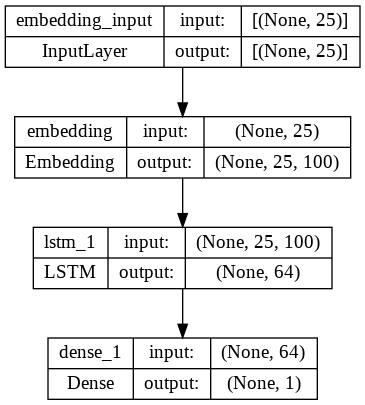

In [ ]:
# https://keras.io/guides/keras_tuner/getting_started/
# https://stackoverflow.com/questions/43196636/how-to-concatenate-two-layers-in-keras
# https://towardsdatascience.com/combining-numerical-and-text-features-in-deep-neural-networks-e91f0237eea4


from tensorflow.keras.utils import plot_model
# -- Builds RNN Model with Tuning-- 
def build_standard_model(hp=None, isBidirectional=False):
  model = Sequential()
  embedding_layer = build_embedding_layer()
  model.add(embedding_layer)
  if isBidirectional:
    model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.25)))
  else:
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  return model

model = build_standard_model()
plot_model(model, show_shapes=True)

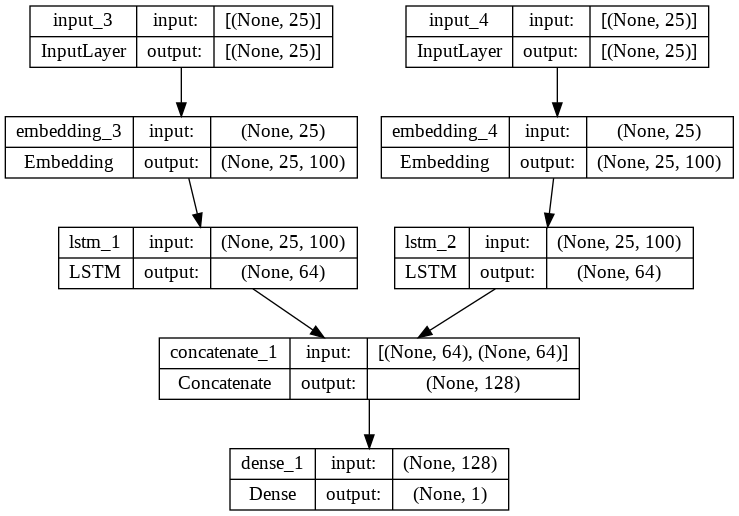

In [ ]:
# -- Stacking parent data to create model with parent data

# seq_length = 25
# embedding_size = len(word_index) + 1

# nlp_input = Input(shape=(seq_length,)) 
# nlp_input2 = Input(shape=(seq_length,))

# emb = Embedding(len(word_index) + 1,
#                             embedding_dim,
#                             weights=[embedding_matrix],
#                             input_length=max_length,
#                             trainable=False)(nlp_input) 
                    
# emb2 = Embedding(len(word_index_parent) + 1,
#                             embedding_dim,
#                             weights=[embedding_matrix_parent],
#                             input_length=max_length,
#                             trainable=False)(nlp_input2) 

# nlp_out = LSTM(64, dropout=0.2, recurrent_dropout=0.25)(emb)
# nlp_out2 = LSTM(64, dropout=0.2, recurrent_dropout=0.25)(emb2)

# concat = concatenate([nlp_out, nlp_out2]) 
# output = Dense(1, activation='sigmoid')(concat) 
# model = Model(inputs=[nlp_input , nlp_input2], outputs=[output])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True)


In [ ]:
# https://www.tensorflow.org/guide/keras/save_and_serialize#how_to_save_and_load_a_model

import keras
import tensorflow as tf 

epochs = 5
epochsSoFar = 0
batch_size = 32
model = build_standard_model(isBidirectional=True)
while epochsSoFar < epochs:
  history = model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test_pad, y_test), verbose=1, callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_acc',
                patience=2,
                restore_best_weights=True
            )
        ])
  epochsSoFar += 1
  model.save('rnn_biLSTM_fullData_final')

In [ ]:
import keras
import tensorflow as tf 

epochs = 5
epochsSoFar = 0
batch_size = 32
model = build_meta_model(isBidirectional=True)
while epochsSoFar < epochs:
  history = model.fit([X_train_pad, x_train_meta], y_train, batch_size=batch_size, epochs=1, validation_data=([X_test_pad, x_test_meta], y_test), verbose=1, callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_acc',
                patience=2,
                restore_best_weights=True
            )
        ])
  epochsSoFar += 1
  model.save('rnn_metadata_biLSTM_fullData_final')

18563/25271 [=====================>........] - ETA: 22:39 - loss: 0.5581 - acc: 0.7091

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

predictions = (model.predict([X_test_pad, x_test_meta]) > 0.5).astype('int32')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)
# auc
auc = roc_auc_score(y_test, model.predict([X_test_pad, x_test_meta]))
print('AUC : %f' % auc)

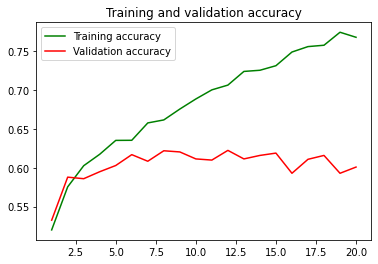

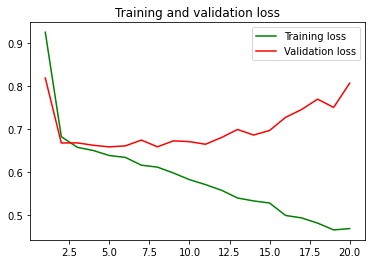

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# -- Test on text --
import math

def predict_sarcasm(s):
    x_final = pd.DataFrame({"comment":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    prob = pred[0][0]
    if prob >= 50:
      label = "Sarcasm"
      return 1 
    else:
      label = "Not Sarcasm"
      return 0
    # return f'{label}: {math.ceil(prob*100)/100}% | {s}'

def get_accuracy():
  total = 0
  correct = 0
  for index, row in truncated_test_df.iterrows():
    predicated_y = predict_sarcasm(row['comment'])
    actual_y = row['label']
    if predicated_y == actual_y:
      correct += 1
    total += 1
  return correct/total

get_accuracy()

In [ ]:
print(predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore."))

print(predict_sarcasm("You just broke my car window. Great job!")) # -- Wrong 

print(predict_sarcasm("You just saved my dog's life. Thanks a million."))

print(predict_sarcasm("I want a million dollars!"))

print(predict_sarcasm("He is such a nice person."))

print(predict_sarcasm("Could you be any smarter?"))

Not Sarcasm: 27.94% | I was depressed. He asked me to be happy. I am not depressed anymore.
Sarcasm: 51.62% | You just broke my car window. Great job!
Sarcasm: 59.01% | You just saved my dog's life. Thanks a million.
Sarcasm: 64.23% | I want a million dollars!
Sarcasm: 57.2% | He is such a nice person.
Sarcasm: 68.0% | Could you be any smarter?


In [ ]:
# import keras
# https://www.tensorflow.org/guide/keras/save_and_serialize#how_to_save_and_load_a_model

# model.save('rnn_model')
# constructed_model = keras.models.load_model("rnn_model")

In [ ]:
import math

def model_predict(model, sArray):
    res = []
    for s in sArray:
      x_final = pd.DataFrame({"comment":[s]})
      test_lines = CleanTokenize(x_final)
      test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
      test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
      pred = model.predict(test_review_pad)
      pred*=100
      prob = pred[0][0]
      if prob >= 50:
        label = "Sarcasm" 
      else:
        label = "Not Sarcasm"
      res.append(f'{label}: {math.ceil(prob*100)/100}% | {s}')
    return res

In [ ]:
model_predict(constructed_model, [
    "I’m not saying I hate you, what I’m saying is that you are literally the Monday of my life.",
    "It’s okay if you don’t like me. Not everyone has good taste.",
    "If you find me offensive. Then I suggest you quit finding me.",
    "I clapped because it’s finished, not because I like it.",
    "Well at least your mom thinks you’re pretty.",
    "Underestimate me, that will be fun!",
    "15-month wait for private home owners to buy resale HDB 'a form of deterrence for buyers with deep pockets",
    "Inflation, COVID-19 vaccines and drug misuse by athletes to be discussed in Parliament",
    "Full speed ahead for businesses this Singapore F1 GP weekend despite manpower crunch",
    "Madam Noorsiah advised Malaysians to be careful when accepting overseas job offers on social media and to verify the authenticity of the employers with the Ministry of Foreign Affairs"
])

['Sarcasm: 51.57% | I’m not saying I hate you, what I’m saying is that you are literally the Monday of my life.',
 'Not Sarcasm: 29.83% | It’s okay if you don’t like me. Not everyone has good taste.',
 'Sarcasm: 53.0% | If you find me offensive. Then I suggest you quit finding me.',
 'Not Sarcasm: 30.59% | I clapped because it’s finished, not because I like it.',
 'Sarcasm: 65.2% | Well at least your mom thinks you’re pretty.',
 'Not Sarcasm: 48.7% | Underestimate me, that will be fun!',
 "Not Sarcasm: 46.47% | 15-month wait for private home owners to buy resale HDB 'a form of deterrence for buyers with deep pockets",
 'Not Sarcasm: 38.47% | Inflation, COVID-19 vaccines and drug misuse by athletes to be discussed in Parliament',
 'Sarcasm: 55.91% | Full speed ahead for businesses this Singapore F1 GP weekend despite manpower crunch',
 'Not Sarcasm: 29.73% | Madam Noorsiah advised Malaysians to be careful when accepting overseas job offers on social media and to verify the authenticity 

**Hyperparameter Tuning**

- GloVe Model/Data
- Epochs, batch size
- Loss functions 
- Embedding layers
- Amount of training data v.s time to train